In [16]:
%matplotlib inline

import copy
import random

from cycler import cycler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

pd.options.mode.chained_assignment = None

In [2]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.prop_cycle'] = cycler('color',dark2_colors)
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [3]:
FEATURE_FILE = '../../data/big_output.txt'
LOGFC_FILE1 = '../../data/Supplementary1.csv'
LOGFC_FILE2 = '../../data/Supplementary2.csv'
GENE_FILE = '../../targetscan_files/Gene_info.txt'
SEED_FILE = '../../seed_dict.csv'
# TS7_human_file = '../../targetscan_files/Summary_Counts_Human7.txt'
TS7_human_file = '~/Downloads/Summary_Counts_Human.txt'

TESTING_SEEDS = ['AAAGUGC', 'AACACUG', 'AAUACUG', 'GAGGUAG', 'AGCAGCA', 'GCAGCAU', 'UGACCUA']

In [213]:
def get_r_squared(x,y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    return r_value**2

def get_logfc(df,gene,seed):
    if gene not in df.index:
        return float('NaN')
    if seed not in df.columns:
        return float('NaN')
    return float(df.loc[gene][seed])

def bar_plot(heights,labels):
    fig = plt.figure(figsize=[10,4])
    ax = plt.subplot()
    xs = range(len(heights))
    ax.bar(xs,heights,color=dark2_colors[0])
    ax.set_xticks([x+0.4 for x in xs])
    ax.set_xticklabels(labels,rotation=90)
    remove_border()

def get_cdf(logFC_list):
    """
    Parameters:
    ==========
    logFC_list: list of floats, list of log fold-change values to plot CDF
    
    Returns:
    =======
    list of floats: bin indices
    list of floats: cdf values corresponding to the bin indices
    """
    if len(logFC_list) < 5:
        return [],[]
    num_bins = len(logFC_list)/5
    counts,bin_edges = np.histogram(logFC_list,bins=num_bins)
    counts = counts / float(sum(counts))
    return bin_edges[1:],np.cumsum(counts)

In [5]:
GENE_INFO = pd.read_csv(GENE_FILE,sep='\t').drop(['Gene description','Species ID'],1)
GENE_INFO = GENE_INFO.groupby('Gene symbol').agg(lambda x:tuple(x))
GENE_INFO.loc[:,'Isoform ratio'] = [float(max(x))/np.nansum(x) for x in GENE_INFO['3P-seq tags + 5']]
GENE_INFO.loc[:,'Transcript ID'] = [x[y.index(1)] for (x,y) in zip(GENE_INFO['Transcript ID'],GENE_INFO['Representative transcript?'])]
GENE_INFO = GENE_INFO[['Transcript ID','Isoform ratio']]

SEED_INFO = pd.read_csv(SEED_FILE,sep='\t')
SEED_DICT = {}
for row in SEED_INFO.iterrows():
    SEED_DICT[row[1]['col']] = row[1]['seed']

SEEDS = SEED_DICT.values()
TRAINING_SEEDS = list(set(SEEDS)-set(TESTING_SEEDS))

In [6]:
# random.seed(0)
# random.shuffle(SEEDS)
# TRAINING_SEEDS = SEEDS[:74]
# TESTING_SEEDS = SEEDS[74:]

In [10]:
training_ids = pd.read_csv(LOGFC_FILE1)
training_ids['Transcript ID'] = list(GENE_INFO.loc[training_ids['Gene symbol']]['Transcript ID'])
training_ids = training_ids.dropna(subset=['Transcript ID'])
training_ids = training_ids[training_ids['Used in training'] == 'yes']
training_ids = list(training_ids['Transcript ID'])

In [12]:
logFCs1 = pd.read_csv(LOGFC_FILE1)
logFCs1['Transcript ID'] = list(GENE_INFO.loc[logFCs1['Gene symbol']]['Transcript ID'])
logFCs1['Isoform ratio1'] = list(GENE_INFO.loc[logFCs1['Gene symbol']]['Isoform ratio'])
logFCs1 = logFCs1.drop(['Used in training','RefSeq ID','Gene symbol'],1).dropna(subset=['Transcript ID'])
logFCs1 = logFCs1.drop_duplicates(subset=['Transcript ID']).set_index('Transcript ID')
logFCs1.columns = [SEED_DICT[x] if x in SEED_DICT else x for x in logFCs1.columns]

logFCs2 = pd.read_csv(LOGFC_FILE2)
logFCs2['Transcript ID'] = list(GENE_INFO.loc[logFCs2['Gene symbol']]['Transcript ID'])
logFCs2['Isoform ratio2'] = list(GENE_INFO.loc[logFCs2['Gene symbol']]['Isoform ratio'])
logFCs2 = logFCs2.drop(['RefSeq ID','Gene symbol'],1).dropna(subset=['Transcript ID'])
logFCs2 = logFCs2.drop_duplicates(subset=['Transcript ID']).set_index('Transcript ID')
logFCs2.columns = [SEED_DICT[x] if x in SEED_DICT else x for x in logFCs2.columns]

logFCs = pd.concat([logFCs1,logFCs2],axis=1,join='outer')
logFCs.head()

,UCGUAGG,UCAUCUC,UGCUCUU,UUUGGAA,UUGGAAC,CAAACAC,AAUACAC,UUUCCUC,AGCUUCC,AGUCAGA,UGAGCCC,AAGCUUC,GGCAGUG,UUUCCAU,AAAGCAG,...,UGGUCCC,GUAGUGU,CAGUGCA,ACAUUCA,GGAAUGU,AAGGCAC,Isoform ratio1,AGCAGCA,AAAGUGC,AACACUG,AAUACUG,UGACCUA,GAGGUAG,GCAGCAU,Isoform ratio2
ENST00000000233.5,0.069,0.018,0.048,-0.033,-0.076,-0.007,0.059,0.055,-0.019,0.065,0.035,-0.010,0.020,-0.066,0.157,...,-0.058,0.080,0.163,-0.003,0.125,0.135,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENST00000000412.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.116,-0.029,-0.127,0.111,0.074,0.000,1.000000,-0.098,-0.514,-0.056,0.031,-0.003,0.039,0.078,1.000000
ENST00000001008.4,-0.016,-0.557,0.110,0.241,-0.231,0.054,-0.031,0.160,-0.021,0.099,0.136,0.075,0.165,-0.063,0.156,...,-0.198,-0.069,-0.255,-0.067,0.128,0.056,1.000000,0.016,0.133,0.007,-0.114,-0.166,0.002,0.038,1.000000
ENST00000001146.2,-0.200,0.114,0.226,-0.051,-0.284,0.062,0.132,-0.024,-0.001,0.136,0.157,-0.113,-0.127,-0.055,-0.064,...,-0.295,0.067,-0.111,0.278,0.513,0.203,1.000000,-0.080,-0.053,-0.211,0.150,0.021,0.275,-0.336,1.000000
ENST00000002165.6,-0.058,0.092,0.036,0.038,-0.191,0.067,0.057,0.046,-0.055,-0.075,0.015,0.076,0.011,0.086,0.087,...,0.040,-0.108,0.156,0.101,NaN,NaN,0.999025,0.063,0.024,-0.018,0.178,0.015,0.031,-0.176,0.999025


In [284]:
features = pd.read_csv(FEATURE_FILE, sep='\t')

features['logFC'] = [get_logfc(logFCs,gene,seed) for (gene,seed) in zip(features['Gene ID'],features['Seed'])]
print len(features)
features = features.dropna()
print len(features)
isoform_ratios = [y if np.isnan(x) else x for (x,y) in zip(logFCs['Isoform ratio1'],logFCs['Isoform ratio2'])]
logFCs['Isoform ratio'] = isoform_ratios

features['Isoform ratio'] = list(logFCs.loc[features['Gene ID']]['Isoform ratio'])
features['Num sites'] = [1]*len(features)
num_sites = features.groupby(['Gene ID','Seed']).agg({'Num sites':np.nansum})
features['Num sites'] = list(num_sites.loc[zip(features['Gene ID'],features['Seed'])]['Num sites'])
features['ID'] = [x + y for (x,y) in zip(features['Gene ID'],features['Seed'])]
features.head()

1172228
565890


,Gene ID,miRNA family,Mirbase ID,miRNA sequence,Seed,Site type,Site start,Site end,Threep score,Local AU score,Min dist score,UTR length score,Off6m score,SA,siRNA 1A,...,site 8A,site 8C,site 8G,PCT,Conserved,Branch length score,UTR BLS,TA,SPS,ORF length,ORF 8mers,logFC,Isoform ratio,Num sites,ID
0,ENST00000171111.5,UGCUCUU,UGCUCUU,AUGCUCUUUCCUCCUGUGC,UGCUCUU,7mer-m8,236,243,2.0,0.353693,2.372912,2.718562,0.000000e+00,-2.472190,1,...,0,0,0,0,0,0,3.977292,3.586,-7.98,3.276002,0,0.085,1,1,ENST00000171111.5UGCUCUU
1,ENST00000171111.5,UUUGGAA,UUUGGAA,UUUUGGAACAGUCUUUCCG,UUUGGAA,6mer,158,164,4.5,0.386731,2.198657,2.718562,-4.821637e-17,-1.159222,0,...,0,0,1,0,0,0,3.977292,3.709,-4.59,3.276002,0,-0.145,1,1,ENST00000171111.5UUUGGAA
2,ENST00000171111.5,UUGGAAC,UUGGAAC,UUUGGAACAGUCUUUCCGA,UUGGAAC,6mer,487,493,1.5,0.633358,1.478166,2.718562,0.000000e+00,-2.482308,0,...,0,0,0,0,0,0,3.977292,3.635,-4.59,3.276002,0,-0.090,1,1,ENST00000171111.5UUGGAAC
3,ENST00000171111.5,UUUCCUC,UUUCCUC,CUUUCCUCCUGUGCCAUCU,UUUCCUC,7mer-1a,492,499,1.5,0.713298,1.381516,2.718562,0.000000e+00,-2.573604,0,...,1,0,0,0,0,0,3.977292,3.887,-4.56,3.276002,0,0.072,1,1,ENST00000171111.5UUUCCUC
4,ENST00000171111.5,UUUCCAU,miR-8824,AUUUCCAUUGAUGACAAGC,UUUCCAU,6mer,232,238,0.5,0.313684,2.365488,2.718562,0.000000e+00,-1.896143,1,...,0,0,1,0,0,0,3.977292,3.856,-4.59,3.276002,0,0.149,1,2,ENST00000171111.5UUUCCAU


In [14]:
targetscan7 = pd.read_csv(TS7_human_file,sep='\t',usecols=['Transcript ID','miRNA family','Total num conserved sites','Number of 6mer sites',
                                                           'Total num nonconserved sites','Cumulative weighted context++ score'])
targetscan7 = targetscan7[targetscan7['Transcript ID'].isin(GENE_INFO['Transcript ID'])]
targetscan7 = targetscan7[targetscan7['miRNA family'].isin(SEEDS)]
targetscan7.loc[:,'logFC'] = [get_logfc(logFCs,gene,seed) for (gene,seed) in zip(targetscan7['Transcript ID'],targetscan7['miRNA family'])]
targetscan7 = targetscan7.dropna()
targetscan7.loc[:,'Isoform ratio'] = list(logFCs.loc[targetscan7['Transcript ID']]['Isoform ratio'])
targetscan7.loc[:,'Num sites'] = targetscan7['Total num conserved sites'] + targetscan7['Total num nonconserved sites']

targetscan7.head()

,Transcript ID,miRNA family,Total num conserved sites,Total num nonconserved sites,Number of 6mer sites,Cumulative weighted context++ score,logFC,Isoform ratio,Num sites
172,ENST00000000233.5,GGAAGAC,0,1,0,-0.010,0.044,1,1
285,ENST00000000412.3,CUUUGGU,1,0,0,-0.360,-0.045,1,1
286,ENST00000000412.3,AAAGUGC,1,1,0,-0.037,-0.514,1,2
287,ENST00000000412.3,AGCAGCA,1,1,0,-0.035,-0.098,1,2
290,ENST00000000412.3,AAUACUG,0,1,0,-0.011,0.031,1,1


In [17]:
ts7_testing = targetscan7[targetscan7['miRNA family'].isin(TESTING_SEEDS)]
ts7_testing.loc[:,'ID'] = [x + y for (x,y) in zip(ts7_testing['Transcript ID'],ts7_testing['miRNA family'])]
print len(ts7_testing)
ts7_testing = ts7_testing.groupby('ID').first()
ts7_testing.head()

12886


,Transcript ID,miRNA family,Total num conserved sites,Total num nonconserved sites,Number of 6mer sites,Cumulative weighted context++ score,logFC,Isoform ratio,Num sites
ID,,,,,,,,,
ENST00000000412.3AAAGUGC,ENST00000000412.3,AAAGUGC,1,1,0,-0.037,-0.514,1,2
ENST00000000412.3AAUACUG,ENST00000000412.3,AAUACUG,0,1,0,-0.011,0.031,1,1
ENST00000000412.3AGCAGCA,ENST00000000412.3,AGCAGCA,1,1,0,-0.035,-0.098,1,2
ENST00000000412.3GCAGCAU,ENST00000000412.3,GCAGCAU,0,1,1,-0.015,0.078,1,1
ENST00000001008.4GAGGUAG,ENST00000001008.4,GAGGUAG,0,2,0,-0.017,0.002,1,2


In [18]:
print get_r_squared(list(targetscan7['logFC']),list(targetscan7['Cumulative weighted context++ score']))
vikram_set = targetscan7[targetscan7['miRNA family'].isin(TESTING_SEEDS)]
print len(vikram_set)
print get_r_squared(list(vikram_set['logFC']),list(vikram_set['Cumulative weighted context++ score']))

vikram_set = vikram_set[vikram_set['Isoform ratio'] > 0.9]
print len(vikram_set)
print get_r_squared(list(vikram_set['logFC']),list(vikram_set['Cumulative weighted context++ score']))

vikram_set = vikram_set[vikram_set['Number of 6mer sites'] == 1]
print len(vikram_set)
print get_r_squared(list(vikram_set['logFC']),list(vikram_set['Cumulative weighted context++ score']))

vikram_set = vikram_set[vikram_set['Num sites'] == 1]
print len(vikram_set)
print get_r_squared(list(vikram_set['logFC']),list(vikram_set['Cumulative weighted context++ score']))


0.0643592785912
12886
0.152210970068
9868
0.161731268588
2758
0.17691967756
1919
0.130304074688


In [207]:
class SiteSpecific(object):

    def __init__(self, normalize=False):
        self.ols_models = [LinearRegression(normalize=normalize) for i in range(4)]
        self.site_maxes = [-0.03,-0.02,-0.01,0]
#         self.site_maxes = [np.infty]*4

    def fit(self, data, cols):
        for i,sitetype in enumerate(['8mer-1a', '7mer-m8', '7mer-1a', '6mer']):
            subdf = data[data['Site type'] == sitetype]
            if len(subdf) == 0:
                continue
            self.ols_models[i].fit(subdf[cols],subdf['logFC'].values)

    def predict(self, data, cols):
        mydata = copy.deepcopy(data)
        mydata['ix'] = range(len(mydata))
        ixs, values = [], []
        for i,sitetype in enumerate(['8mer-1a', '7mer-m8', '7mer-1a', '6mer']):
            subdf = mydata[mydata['Site type'] == sitetype]
            if len(subdf) == 0:
                continue
            ixs += list(subdf['ix'])
            predictions = self.ols_models[i].predict(subdf[cols])
            values += [min(self.site_maxes[i],p) for p in predictions]

        return np.array(values)[np.argsort(ixs)]

    def score(self, data, cols):
        actual = list(data['logFC'])
        predicted = list(self.predict(data, cols))
        scores = []
        for i,sitetype in enumerate(['8mer-1a', '7mer-m8', '7mer-1a', '6mer']):
            subdf = data[data['Site type'] == sitetype]
            if len(subdf) == 0:
                continue
            scores.append(self.ols_models[i].score(subdf[cols].values,subdf['logFC'].values))
        
        scores.append(get_r_squared(actual, predicted))

        return scores
    
    def get_coefs(self):
        coefs = []
        intercepts = []
        for i in range(4):
            try:
                coefs.append(list(self.ols_models[i].coef_))
                intercepts.append(self.ols_models[i].intercept_)
            except:
                continue
        
        return coefs,intercepts

In [267]:
cols = ['Threep score','Local AU score','Min dist score','TA', 'SPS',
        'UTR length score','Off6m score','SA',
        'siRNA 1A', 'siRNA 1C', 'siRNA 1G', 'siRNA 8A',
        'siRNA 8C', 'siRNA 8G', 'site 8A', 'site 8C', 'site 8G', 
        'PCT','ORF length','ORF 8mers']


training = features[features['Seed'].isin(TRAINING_SEEDS)]
# training = training[training['Isoform ratio'] > 0.9]
training = training[training['Gene ID'].isin(training_ids)]
print len(training)

testing = features[features['Seed'].isin(TESTING_SEEDS)]
testing = testing[testing['ID'].isin(ts7_testing.index)]
# testing = testing[testing['Site type'] != '6mer']
print len(testing)

training_one_site = training[training['Num sites'] == 1]
testing_one_site = testing[testing['Num sites'] == 1]

print len(training_one_site)
print len(testing_one_site)

site_specific = SiteSpecific()
site_specific.fit(training_one_site, cols)
print site_specific.score(training_one_site, cols)
print site_specific.score(testing_one_site, cols)


training['single site score'] = site_specific.predict(training,cols)
original = training.groupby(['Gene ID','Seed']).agg({'single site score': np.nansum,'logFC':lambda x: tuple(x)[0]})
# print len(original)
print get_r_squared(original['single site score'],original['logFC'])


testing['single site score'] = site_specific.predict(testing,cols)
original = testing.groupby(['Gene ID','Seed']).agg({'single site score': np.nansum,'logFC':lambda x: tuple(x)[0]})
# print len(original)
print get_r_squared(original['single site score'],original['logFC'])

134754
29400
44627
5123
[0.1736755777459289, 0.10136575780779165, 0.070356722359784962, 0.021695982582135898, 0.11057461016428195]
[0.04117008082771223, 0.060161561494660454, 0.070122687451270038, 0.08052529831713684, 0.094561811633892309]
0.107278957468
0.107259436895


In [457]:
training.to_csv('../../data/training.txt',sep='\t',index=False)
testing.to_csv('../../data/testing.txt',sep='\t',index=False)

In [450]:
def organize0(data,site_specific):
        subdf = copy.deepcopy(data)
        subdf['special id'] = range(len(data))
        subdf['single site score'] = site_specific.predict(data,cols)
        subdf = subdf.groupby('ID').agg({'single site score': lambda x: tuple(x),
                                                       'logFC': lambda x: tuple(x)[0],
                                                       'Site type': lambda x: tuple(x),
                                                       'Site end': lambda x: tuple(x),
                                                       'Num sites': lambda x: tuple(x)[0],
                                                       'UTR length score': np.nanmean,
                                                       'special id':lambda x: tuple(x)})
        subdf['Num coop'] = [get_num_coop(locs,sites) for (locs,sites) in zip(subdf['Site end'],subdf['Site type'])]
        subdf['Num sites score'] = np.divide(subdf['Num sites'],subdf['UTR length score'])
        subdf['Num coop score'] = np.divide(subdf['Num coop'],subdf['UTR length score'])
        subdf['Single site score'] = [sum(x) for x in subdf['single site score']]
        return subdf

def organize(data,site_specific):
        subdf = copy.deepcopy(data)
        subdf['special id'] = range(len(data))
        subdf['single site score'] = site_specific.predict(data,cols)
        subdf = subdf.groupby(['Gene ID','Seed']).agg({'single site score': lambda x: tuple(x),
                                                       'logFC': np.nansum,
                                                       'Site type': lambda x: tuple(x),
                                                       'Site end': lambda x: tuple(x),
                                                       'Num sites': lambda x: tuple(x)[0],
                                                       'UTR length score': np.nanmean,
                                                       'special id':lambda x: tuple(x)})
        subdf['Num coop'] = [get_num_coop(locs,sites) for (locs,sites) in zip(subdf['Site end'],subdf['Site type'])]
        subdf['Num sites score'] = np.divide(subdf['Num sites'],subdf['UTR length score'])
        subdf['Num coop score'] = np.divide(subdf['Num coop'],subdf['UTR length score'])
        subdf['Single site score'] = [sum(x) for x in subdf['single site score']]
        return subdf

class MultiSite(object):
    
    def __init__(self, normalize=False):
        self.ols_model = LinearRegression(normalize=normalize)
    
    def fit(self,data):
        Ytrain = np.subtract(data['logFC'].values,data['Single site score'].values)
        self.ols_model.fit(data[['Num sites score','Num coop score']],Ytrain)
        predicted = self.ols_model.predict(data[['Num sites score','Num coop score']])
        print 'Training score: {}'.format(get_r_squared(np.add(predicted,data['Single site score']),data['logFC']))
    
    def predict(self,data):
        Ytest = np.subtract(data['logFC'].values,data['Single site score'].values)
        return self.ols_model.predict(data[['Num sites score','Num coop score']])
    
    def score(self,data):
        predicted = np.add(self.predict(data),data['Single site score'].values)
        print get_r_squared(list(data['Single site score']),list(data['logFC']))
        return get_r_squared(predicted,data['logFC'])

    def get_coefs(self):
        return self.ols_model.coef_, self.ols_model.intercept_

def prepare_data_for_site_specific(data, original):
    data = copy.deepcopy(data)
    data['adjusted logFC'] = np.subtract(data['logFC'],data['multiscore'])
    new_logfcs = [[(x/site_score)*logfc if (site_score != 0) else (logfc/len(site_scores)) for x in site_scores] for (site_score,site_scores,logfc) in zip(data['Single site score'],
                                                                                                                                 data['single site score'],
                                                                                                                                 data['adjusted logFC'])]
    ids = reduce(lambda x,y: x+y, list(data['special id']))
    new_logfcs = np.array(reduce(lambda x,y: x+y, new_logfcs))
    return_df = copy.deepcopy(original)
    return_df['logFC'] = new_logfcs[np.argsort(ids)]

    return return_df
        

In [401]:
mtraining = organize0(training,site_specific)
multisite = MultiSite()
multisite.fit(mtraining)

Training score: 0.108085571116


In [455]:
site_specific = SiteSpecific()
site_specific.fit(training_one_site, cols)

mtraining = organize0(training,site_specific)
multisite = MultiSite()
multisite.fit(mtraining)
mtraining['multiscore'] = multisite.predict(mtraining)
print multisite.get_coefs()

straining = prepare_data_for_site_specific(mtraining,training)
for i in range(10):
    site_specific = SiteSpecific()
    site_specific.fit(straining,cols)
    
    mtraining = organize0(training,site_specific)
    multisite = MultiSite()
    multisite.fit(mtraining)
    mtraining['multiscore'] = multisite.predict(mtraining)
    print multisite.get_coefs()

    straining = prepare_data_for_site_specific(mtraining,training)

Training score: 0.108085571116
(array([ 0.01580166, -0.14323027]), 0.0012088115957567085)
Training score: 0.105704127091
(array([ 0.03015676, -0.12783702]), 0.0042100604322623039)
Training score: 0.105854739476
(array([ 0.03856247, -0.12008807]), 0.0080275183305173262)
Training score: 0.105937413427
(array([ 0.04588124, -0.11618763]), 0.011087994249188309)


KeyboardInterrupt: 

In [452]:
mtraining = organize0(training,site_specific)
# originalt = training.groupby(['Gene ID','Seed']).agg({'single site score': np.nansum,'logFC':lambda x: tuple(x)[0]})
print np.nanmean(originalt['logFC'])
print np.nanmean(mtraining['logFC'])

-0.0483608186743
-0.0483608186743


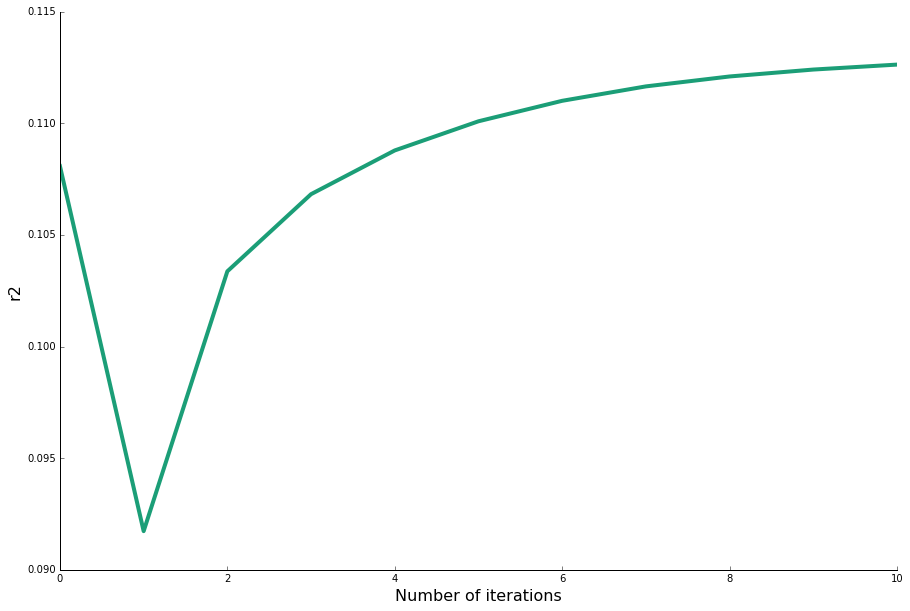

In [421]:
training_scores = [0.108085571116, 0.0917308842115, 0.103372442672, 0.106828710831, 0.108788683068, 
                   0.11009436374, 0.111011824371, 0.111657791314, 0.112102540093, 0.112412362107, 0.112634404266]
fig = plt.figure(figsize=(15,10))
ax = plt.subplot()
ax.plot(range(len(training_scores)),training_scores,linewidth=4)
ax.set_ylabel('r2',fontsize=16)
ax.set_xlabel('Number of iterations',fontsize=16)
remove_border()

In [445]:
print multisite.get_coefs()

(array([-0.13314312, -1.01767063]), 0.15045398909798724)


In [443]:
mtesting = organize0(testing,site_specific)
print np.nanmean(mtesting['logFC'])
predicted = np.add(multisite.predict(mtesting),mtesting['Single site score'].values)
print get_r_squared(list(mtesting['Single site score']),list(mtesting['logFC']))
print get_r_squared(predicted,mtesting['logFC'])
mtesting['combined score'] = predicted
# multisite.score(mtesting)

0.0957266381426
0.0593143663167


In [444]:
print np.nanmean(original['logFC'])
print np.nanmean(mtesting['logFC'])

-0.0690135901219
-0.0690135901219


180255
14101
0.0420569915652
0.0865298609695
[-0.00379962 -0.04374497  0.0104873   0.04902465  0.03637811  0.07047258
  0.0068304  -0.03288424 -0.00765774  0.00570432 -0.01782521  0.01890374
  0.00620702  0.03296879  0.01275662 -0.00980113  0.01152939  0.          0.
  0.        ]
-0.0551758110883


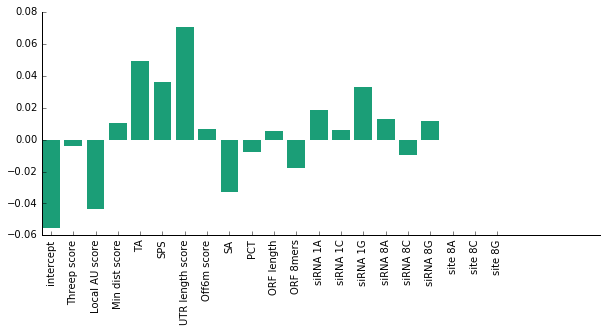

In [142]:
cols_cont = ['Threep score','Local AU score','Min dist score','TA', 'SPS',
        'UTR length score','Off6m score','SA', 
        'PCT','ORF length','ORF 8mers']

cols_bin = ['siRNA 1A', 'siRNA 1C', 'siRNA 1G', 
            'siRNA 8A','siRNA 8C', 'siRNA 8G', 
            'site 8A', 'site 8C', 'site 8G']

cols = cols_cont + cols_bin

myfeatures = features[features['Isoform ratio'] > 0.9]
myfeatures = myfeatures[myfeatures['Site type'] != '6mer']
training = myfeatures[myfeatures['Seed'].isin(TRAINING_SEEDS)]
training_one_site = training[training['Num sites'] == 1]
print len(training)

testing = myfeatures[myfeatures['Seed'].isin(TESTING_SEEDS)]
testing_one_site = testing[testing['Num sites'] == 1]
print len(testing)

# print len(training_one_site)
# print len(testing_one_site)

stype = '7mer-m8'
subdf = training_one_site[training_one_site['Site type'] == stype]
subdf2 = testing_one_site[testing_one_site['Site type'] == stype]
for col in cols:
    if col not in cols_bin:
#         min_,std = np.min(subdf[col]),np.nanstd(subdf[col])
        mean,std = np.nanmean(subdf[col]),np.nanstd(subdf[col])
        subdf[col] = (subdf[col]-mean)/(2*std)
        subdf2[col] = (subdf2[col]-mean)/(2*std)
mod = LinearRegression(normalize=False)
mod.fit(subdf[cols],subdf['logFC'])
print mod.score(subdf[cols],subdf['logFC'])
print mod.score(subdf2[cols],subdf2['logFC'])
print mod.coef_
print mod.intercept_
bar_plot([mod.intercept_] + list(mod.coef_),['intercept'] + cols)

# site_specific = SiteSpecific('linreg')
# site_specific.fit(training_one_site, cols)
# coefs,intercepts = site_specific.get_coefs()
# print intercepts
# ratios1 = np.divide(coefs[0],coefs[2])
# ratios2 = np.divide(coefs[1],coefs[2])
# print site_specific.score(training_one_site, cols)
# print site_specific.score(testing_one_site, cols)

134754
18363
44627
5117
[0.1736755777459289, 0.10136575780779165, 0.070356722359784962, 0.021695982582135898, 0.10716112992956682]
[0.04117008082771223, 0.060161561494660454, 0.070122687451270038, 0.095662718084016662]
12865
0.0745101815282


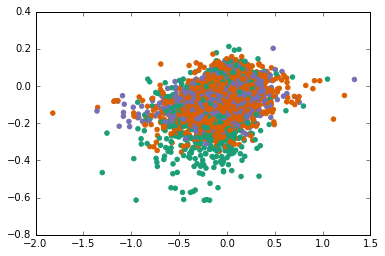

In [205]:
cols = ['Threep score','Local AU score','Min dist score','TA', 'SPS',
        'UTR length score','Off6m score','SA',
        'siRNA 1A', 'siRNA 1C', 'siRNA 1G', 'siRNA 8A',
        'siRNA 8C', 'siRNA 8G', 'site 8A', 'site 8C', 'site 8G', 
        'PCT','ORF length','ORF 8mers']

# cols = ['Threep score','Local AU score','Min dist score','TA', 'SPS']

# myfeatures = features[features['Isoform ratio'] > 0.9]

training = features[features['Seed'].isin(TRAINING_SEEDS)]
training = training[training['Gene ID'].isin(training_ids)]
print len(training)

testing = features[features['Seed'].isin(TESTING_SEEDS)]
testing = testing[testing['ID'].isin(ts7_testing.index)]
testing = testing[testing['Site type'] != '6mer']
print len(testing)

training_one_site = training[training['Num sites'] == 1]
testing_one_site = testing[testing['Num sites'] == 1]

# training_one_site = training_one_site[training_one_site['Site type'] != '6mer']
# testing_one_site = testing_one_site[testing_one_site['Site type'] != '6mer']

print len(training_one_site)
print len(testing_one_site)

site_specific = SiteSpecific('linreg')
site_specific.fit(training_one_site, cols)
print site_specific.score(training_one_site, cols)
print site_specific.score(testing_one_site, cols)
types = [['8mer-1a','7mer-m8','7mer-1a','6mer'].index(x) for x in testing_one_site['Site type']]
colors = [dark2_colors[i] for i in types]
actuals = testing_one_site['logFC']
predicted = site_specific.predict(testing_one_site,cols)
plt.scatter(actuals,predicted,color=colors)

testing['single site score'] = site_specific.predict(testing,cols)
original = testing.groupby(['Gene ID','Seed']).agg({'single site score': np.nansum,'logFC':lambda x: tuple(x)[0]})
print len(original)
print get_r_squared(original['single site score'],original['logFC'])

In [20]:
def get_num_coop(locs,types):
    upper = 46
    lower = 13
    locs = [l for (l,t) in zip(locs,types) if t != '6mer']
    if len(locs) < 2:
        return 0
    num_coop = 0
    for i in range(len(locs)-1):
        diff = locs[i+1] - locs[i]
        if (diff < 46) & (diff > 13):
            num_coop += 1
    return num_coop

In [ ]:
class MultiSite(object):

    def __init__(self):
        self.feature_model = LinearRegression()
        self.site_model = LinearRegression()
        self.num_site_types = 4
        self.num_features = 0
        self.site_multipliers = [1,1,1,1]
    
    def organize(self, data, cols):
        num_coop = [get_num_coop(locs,types) for (locs,types) in zip(data['Site end'],data['Site type'])]
        Ytrain = data['logFC'].values
        Xtrain = np.zeros((len(data),len(cols)*4))
        print Xtrain.shape
        i = 0
        for col in cols:
            for sitetype in ['8mer-1a', '7mer-m8', '7mer-1a', '6mer']:
                new_col = [sum([y for (x,y) in zip(stypes,col_vals) if x == sitetype]) for (stypes,col_vals) in zip(data['Site type'],data[col])]
                Xtrain[:,i] = new_col
                i += 1
        return Xtrain,Ytrain,num_coop

    def fit(self, Xtrain, Ytrain, num_coop, cols, max_iter=1000, threshold=0.0001):
        self.num_features = len(cols)
        i = 0
        while i < max_iter:
            Xtrain_features = np.zeros((len(Ytrain),self.num_features+1))
            for j in range(self.num_features):
                Xtrain_features[:,j] = np.dot(Xtrain[:,j*self.num_site_types:(j+1)*self.num_site_types],self.site_multipliers)
            Xtrain_features[:,j+1] = num_coop
            self.feature_model.fit(Xtrain_features,Ytrain)
            feature_intercept = self.feature_model.intercept_
            feature_params = self.feature_model.coef_[:-1]
            
            Xtrain_sites = np.empty((len(Ytrain),self.num_site_types+1))
            for j in range(self.num_site_types):
                Xtrain_sites[:,j] = np.dot(Xtrain[:,[(k*4)+j for k in range(self.num_features)]],feature_params)
            Xtrain_sites[:,j+1] = num_coop
            self.site_model.fit(Xtrain_sites,Ytrain)
            site_intercept = self.site_model.intercept_
            self.site_multipliers = self.site_model.coef_[:-1]
            
            if abs((site_intercept-feature_intercept)/site_intercept) < threshold:
                return
        print "reached maximum number of iterations"

    def predict(self, X, num_coop):
        myX = np.zeros((X.shape[0],self.num_features+1))
        for j in range(self.num_features):
            myX[:,j] = np.dot(X[:,j*self.num_site_types:(j+1)*self.num_site_types],self.site_multipliers)
        myX[:,j+1] = num_coop
        return self.feature_model.predict(myX)

    def score(self, X, Y, num_coop, cols):
        myX = np.zeros((X.shape[0],self.num_features+1))
        for j in range(self.num_features):
            myX[:,j] = np.dot(X[:,j*self.num_site_types:(j+1)*self.num_site_types],self.site_multipliers)
        myX[:,j+1] = num_coop
        return self.feature_model.score(myX,Y)
        

In [175]:
class MultiSiteSimple(object):

    def __init__(self):
        self.feature_model = LinearRegression()
        self.site_model = LinearRegression()
        self.num_site_types = 4
        self.num_features = 0
        self.site_multipliers = [1,1,1,1]
    
    def organize(self, data, cols):
        Ytrain = data['logFC'].values
        Xtrain = np.zeros((len(data),len(cols)*4))
        print Xtrain.shape
        i = 0
        final_cols = []
        for col in cols:
            for sitetype in ['8mer-1a', '7mer-m8', '7mer-1a', '6mer']:
                new_col = [sum([y for (x,y) in zip(stypes,col_vals) if x == sitetype]) for (stypes,col_vals) in zip(data['Site type'],data[col])]
                Xtrain[:,i] = new_col
                i += 1
                final_cols.append('{} {}'.format(col,sitetype))
        return Xtrain,Ytrain,final_cols

    def fit(self, Xtrain, Ytrain, cols, max_iter=1000, threshold=0.0001):
        self.num_features = len(cols)
        i = 0
        while i < max_iter:
            Xtrain_features = np.zeros((len(Ytrain),self.num_features))
            for j in range(self.num_features):
                Xtrain_features[:,j] = np.dot(Xtrain[:,j*self.num_site_types:(j+1)*self.num_site_types],self.site_multipliers)
            self.feature_model.fit(Xtrain_features,Ytrain)
            feature_intercept = self.feature_model.intercept_
            feature_params = self.feature_model.coef_
            
            Xtrain_sites = np.empty((len(Ytrain),self.num_site_types))
            for j in range(self.num_site_types):
                Xtrain_sites[:,j] = np.dot(Xtrain[:,[(k*4)+j for k in range(self.num_features)]],feature_params)
            self.site_model.fit(Xtrain_sites,Ytrain)
            site_intercept = self.site_model.intercept_
            self.site_multipliers = self.site_model.coef_
            
            if abs((site_intercept-feature_intercept)/site_intercept) < threshold:
                return
        print "reached maximum number of iterations"

    def predict(self, X):
        myX = np.zeros((X.shape[0],self.num_features))
        for j in range(self.num_features):
            myX[:,j] = np.dot(X[:,j*self.num_site_types:(j+1)*self.num_site_types],self.site_multipliers)
        return self.feature_model.predict(myX)

    def score(self, X, Y, cols):
        myX = np.zeros((X.shape[0],self.num_features))
        for j in range(self.num_features):
            myX[:,j] = np.dot(X[:,j*self.num_site_types:(j+1)*self.num_site_types],self.site_multipliers)
        return self.feature_model.score(myX,Y)
        

In [128]:
multitraining = training.drop(['miRNA family','Mirbase ID','miRNA sequence','Isoform ratio','Num sites'],1)
multitraining = multitraining.groupby(['Gene ID','Seed']).agg(lambda x: tuple(x))
multitraining['logFC'] = [x[0] for x in multitraining['logFC']]
multitraining.head()

Site type     Site start        Site end     Threep score                                   Local AU score                                 Min dist score                             UTR length score      Off6m score                                                 SA   siRNA 1A   siRNA 1C   siRNA 1G   siRNA 8A   siRNA 8C   siRNA 8G    site 8A    site 8C    site 8G              PCT  Conserved Branch length score                               UTR BLS  \
Gene ID           Seed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
ENST00000000233.5 ACACCCU             (7mer-1a,)         (299,)          (306,)           (0.0,)                                (0.577376659306,)                                (1.9692781106,)                             (2.60115836438,)           (0.0,)                                  (-2.05330108254,)       (0,)       (1,)       (0,)       (0,)       (0,)       (0,)       (0,)       (0,)       (0,)           (0.0,)       (0,)              (0.0,)                         (6.33317059,)   
                  AGCUUCC             (7mer-m8,)          (27,)           (34,)           (3.5,)                                (0.199412801411,)                               (1.43136376416,)                              (2.4247588124,)           (0.0,)                                  (-4.02690957126,)       (1,)       (0,)       (0,)       (0,)       (1,)       (0,)       (0,)       (0,)       (0,)           (0.0,)       (0,)              (0.0,)                         (6.33317059,)   
                  AGGAAAA  (6mer, 7mer-m8, 6mer)  (86, 97, 277)  (92, 104, 283)  (1.0, 2.5, 1.0)  (0.25443291905, 0.256190663803, 0.615697534495)  (1.93449845124, 1.97927395495, 2.06509560551)  (2.4247588124, 2.4247588124, 2.60115836438)  (0.0, 0.0, 0.0)  (-1.55668662165, -0.308748626708, -1.83776905891)  (0, 0, 0)  (0, 0, 0)  (0, 0, 0)  (1, 1, 1)  (0, 0, 0)  (0, 0, 0)  (0, 0, 0)  (1, 0, 0)  (0, 0, 1)  (0.0, 0.0, 0.0)  (0, 0, 0)     (0.0, 0.0, 0.0)  (6.33317059, 6.33317059, 6.33317059)   
                  AGGCAGA           (6mer, 6mer)     (135, 204)      (141, 210)       (1.0, 2.0)                 (0.357318750909, 0.300389765024)                 (1.92189267478, 2.27678801611)                (2.4247588124, 2.60115836438)       (0.0, 0.0)                    (-5.20574401084, -3.0081123952)     (0, 0)     (0, 0)     (0, 0)     (1, 1)     (0, 0)     (0, 0)     (0, 0)     (1, 1)     (0, 0)       (0.0, 0.0)     (0, 0)          (0.0, 0.0)              (6.33317059, 6.33317059)   
                  CACCGUA                (6mer,)         (402,)          (408,)           (0.0,)                                (0.639926047236,)                               (1.00513378363,)                             (2.62129981078,)           (0.0,)                                  (-4.01592756135,)       (0,)       (0,)       (0,)       (1,)       (0,)       (0,)       (0,)       (1,)       (0,)           (0.0,)       (0,)              (0.0,)                         (6.33317059,)   

                                              TA                    SPS                                     ORF length  ORF 8mers  logFC                                                 ID  
Gene ID           Seed                                                                                                                                                                       
ENST00000000233.5 ACACCCU               (3.274,)               (-8.57,)                               (2.74585519517,)       (0,) -0.610                        (ENST00000000233.5ACACCCU,)  
          

In [129]:
multitesting = testing.drop(['miRNA family','Mirbase ID','miRNA sequence','Isoform ratio','Num sites'],1)
multitesting = multitesting.groupby(['Gene ID','Seed']).agg(lambda x: tuple(x))
multitesting['logFC'] = [x[0] for x in multitesting['logFC']]
multitesting.head()

Site type    Site start      Site end Threep score                    Local AU score                  Min dist score                UTR length score Off6m score                                SA siRNA 1A siRNA 1C siRNA 1G siRNA 8A siRNA 8C siRNA 8G site 8A site 8C site 8G                                 PCT Conserved       Branch length score                   UTR BLS              TA               SPS                      ORF length ORF 8mers  logFC  \
Gene ID           Seed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
ENST00000000412.3 AAAGUGC  (7mer-1a, 7mer-m8)    (792, 899)    (799, 906)   (0.5, 2.5)  (0.443875232337, 0.452730277007)  (2.81558311738, 2.73799374564)  (3.16226803094, 3.16226803094)  (0.0, 0.0)  (-2.53684519242, -0.83006177838)   (0, 0)   (0, 0)   (0, 0)   (0, 0)   (1, 1)   (0, 0)  (0, 0)  (0, 0)  (0, 0)             (0.00158274175296, 0.0)    (0, 0)  (0.05955713, 0.79425801)  (4.28790592, 4.28790592)  (3.727, 3.727)    (-3.75, -7.17)  (2.92788341033, 2.92788341033)    (1, 1) -0.514   
                  AAUACUG          (7mer-m8,)        (880,)        (887,)       (2.0,)                 (0.556251205612,)                  (2.752822635,)                (3.16226803094,)      (0.0,)                 (-1.30753098439,)     (0,)     (0,)     (0,)     (0,)     (0,)     (1,)    (0,)    (0,)    (0,)                  (0.0220880709747,)      (0,)             (0.50429837,)             (4.28790592,)        (3.614,)          (-5.25,)                (2.92788341033,)      (0,)  0.031   
                  AGCAGCA  (7mer-m8, 7mer-m8)   (476, 1011)   (483, 1018)   (4.5, 1.5)  (0.656967963367, 0.410751236909)  (2.67760695272, 2.63849732903)  (3.16226803094, 3.16226803094)  (0.0, 0.0)  (-3.73883304354, -3.43382646462)   (0, 0)   (0, 0)   (0, 0)   (1, 1)   (0, 0)   (0, 0)  (0, 0)  (0, 0)  (0, 0)  (0.0725527625801, 0.0192189743957)    (0, 0)  (0.84990823, 0.32090909)  (4.28790592, 4.28790592)  (3.667, 3.667)  (-10.23, -10.23)  (2.92788341033, 2.92788341033)    (0, 0) -0.098   
                  GCAGCAU  (7mer-m8, 7mer-1a)  (1010, 1014)  (1017, 1021)   (2.5, 2.0)  (0.467259863046, 0.342864732744)  (2.63949454283, 2.63549187494)  (3.16226803094, 3.16226803094)  (0.0, 0.0)  (-3.25804731144, -3.25398593045)   (1, 1)   (0, 0)   (0, 0)   (0, 0)   (0, 0)   (0, 0)  (0, 0)  (0, 1)  (0, 0)             (0.0, 0.00243948174432)    (0, 0)  (0.32090909, 0.50509035)  (4.28790592, 4.28790592)  (3.586, 3.586)      (-9.7, -8.6)  (2.92788341033, 2.92788341033)    (0, 0)  0.078   
ENST00000001008.4 GAGGUAG  (7mer-m8, 7mer-1a)  (1058, 1696)  (1065, 1703)   (1.0, 2.5)  (0.510500269246, 0.478055367079)  (2.67698815507, 2.65199323184)  (3.18969595343, 3.33278946969)  (0.0, 0.0)   (-1.62544007238, -3.5539567431)   (0, 0)   (0, 0)   (0, 0)   (0, 0)   (0, 0)   (1, 1)  (0, 0)  (0, 0)  (0, 0)                          (0.0, 0.0)    (0, 0)  (0.05955713, 0.00995384)  (2.89643632, 2.89643632)  (3.393, 3.393)    (-9.25, -6.72)  (3.14426277376, 3.14426277376)    (0, 0)  0.002   

                                                                          ID                     single site score  
Gene ID           Seed                                                                                              
ENST00000000412.3 AAAGUGC  (ENST00000000412.3AAAGUGC, ENST00000000412.3AA...             (-0.01, -0.0799538325857)  
                  AAUACUG                        (ENST00000000412.3AAUACUG,)                   (-0.0328957437596,)  
                  AGCAGCA  (ENST00000000412.3AGCAGCA, ENST00000000412.3AG...   (-0.083011130879, -0.0230982737148)  

In [185]:
multisites = MultiSiteSimple()
Xtrain,Ytrain,train_cols = multisites.organize(multitraining,cols)
Xtest,Ytest,test_cols = multisites.organize(multitesting,cols)

(276666, 80)
(12865, 80)


In [186]:
training_sites = [[x.count(stype) for stype in ['8mer-1a','7mer-m8','7mer-1a','6mer']] for x in multitraining['Site type']]
testing_sites = [[x.count(stype) for stype in ['8mer-1a','7mer-m8','7mer-1a','6mer']] for x in multitesting['Site type']]
Xtrainplus = np.append(Xtrain,training_sites,axis=1)
Xtestplus = np.append(Xtest,testing_sites,axis=1)

In [187]:
Xtrain_df = pd.DataFrame(Xtrainplus)
Xtrain_df.columns = train_cols + ['num 8mer-1a','num 7mer-m8','num 7mer-1a','num 6mer']
Xtrain_df = Xtrain_df.drop(['site 8A 8mer-1a', 'site 8C 8mer-1a', 'site 8G 8mer-1a',
                            'site 8A 7mer-m8', 'site 8C 7mer-m8', 'site 8G 7mer-m8'],1)
Xtrain_df['num coop'] = [get_num_coop(locs,types) for (locs,types) in zip(multitraining['Site end'],multitraining['Site type'])]
Xtrain_df.head()

,Threep score 8mer-1a,Threep score 7mer-m8,Threep score 7mer-1a,Threep score 6mer,Local AU score 8mer-1a,Local AU score 7mer-m8,Local AU score 7mer-1a,Local AU score 6mer,Min dist score 8mer-1a,Min dist score 7mer-m8,Min dist score 7mer-1a,Min dist score 6mer,TA 8mer-1a,TA 7mer-m8,TA 7mer-1a,...,PCT 7mer-1a,PCT 6mer,ORF length 8mer-1a,ORF length 7mer-m8,ORF length 7mer-1a,ORF length 6mer,ORF 8mers 8mer-1a,ORF 8mers 7mer-m8,ORF 8mers 7mer-1a,ORF 8mers 6mer,num 8mer-1a,num 7mer-m8,num 7mer-1a,num 6mer,num coop
0,0,0.0,0,0,0,0.000000,0.577377,0.000000,0,0.000000,1.969278,0.000000,0,0.000,3.274,...,0,0,0,0.000000,2.745855,0.000000,0,0,0,0,0,0,1,0,0
1,0,3.5,0,0,0,0.199413,0.000000,0.000000,0,1.431364,0.000000,0.000000,0,3.459,0.000,...,0,0,0,2.745855,0.000000,0.000000,0,0,0,0,0,1,0,0,0
2,0,2.5,0,2,0,0.256191,0.000000,0.870130,0,1.979274,0.000000,3.999594,0,3.945,0.000,...,0,0,0,2.745855,0.000000,5.491710,0,0,0,0,0,1,0,2,0
3,0,0.0,0,3,0,0.000000,0.000000,0.657709,0,0.000000,0.000000,4.198681,0,0.000,0.000,...,0,0,0,0.000000,0.000000,5.491710,0,0,0,0,0,0,0,2,0
4,0,0.0,0,0,0,0.000000,0.000000,0.639926,0,0.000000,0.000000,1.005134,0,0.000,0.000,...,0,0,0,0.000000,0.000000,2.745855,0,0,0,0,0,0,0,1,0


In [188]:
Xtest_df = pd.DataFrame(Xtestplus)
Xtest_df.columns = test_cols + ['num 8mer-1a','num 7mer-m8','num 7mer-1a','num 6mer']
Xtest_df = Xtest_df.drop(['site 8A 8mer-1a', 'site 8C 8mer-1a', 'site 8G 8mer-1a',
                            'site 8A 7mer-m8', 'site 8C 7mer-m8', 'site 8G 7mer-m8'],1)
Xtest_df['num coop'] = [get_num_coop(locs,types) for (locs,types) in zip(multitesting['Site end'],multitesting['Site type'])]
Xtest_df.head()

,Threep score 8mer-1a,Threep score 7mer-m8,Threep score 7mer-1a,Threep score 6mer,Local AU score 8mer-1a,Local AU score 7mer-m8,Local AU score 7mer-1a,Local AU score 6mer,Min dist score 8mer-1a,Min dist score 7mer-m8,Min dist score 7mer-1a,Min dist score 6mer,TA 8mer-1a,TA 7mer-m8,TA 7mer-1a,...,PCT 7mer-1a,PCT 6mer,ORF length 8mer-1a,ORF length 7mer-m8,ORF length 7mer-1a,ORF length 6mer,ORF 8mers 8mer-1a,ORF 8mers 7mer-m8,ORF 8mers 7mer-1a,ORF 8mers 6mer,num 8mer-1a,num 7mer-m8,num 7mer-1a,num 6mer,num coop
0,0,2.5,0.5,0,0,0.452730,0.443875,0,0,2.737994,2.815583,0,0,3.727,3.727,...,0.001583,0,0,2.927883,2.927883,0,0,1,1,0,0,1,1,0,0
1,0,2.0,0.0,0,0,0.556251,0.000000,0,0,2.752823,0.000000,0,0,3.614,0.000,...,0.000000,0,0,2.927883,0.000000,0,0,0,0,0,0,1,0,0,0
2,0,6.0,0.0,0,0,1.067719,0.000000,0,0,5.316104,0.000000,0,0,7.334,0.000,...,0.000000,0,0,5.855767,0.000000,0,0,0,0,0,0,2,0,0,0
3,0,2.5,2.0,0,0,0.467260,0.342865,0,0,2.639495,2.635492,0,0,3.586,3.586,...,0.002439,0,0,2.927883,2.927883,0,0,0,0,0,0,1,1,0,0
4,0,1.0,2.5,0,0,0.510500,0.478055,0,0,2.676988,2.651993,0,0,3.393,3.393,...,0.000000,0,0,3.144263,3.144263,0,0,0,0,0,0,1,1,0,0


In [198]:
mod = LinearRegression()
mod.fit(Xtrain_df,Ytrain)
print mod.score(Xtrain_df,Ytrain)
print mod.score(Xtest_df,Ytest)

0.039091094263
0.0912084565402


In [199]:
mod = LinearRegression()
mod.fit(Xtrain_df.drop(['num coop'],1),Ytrain)
print mod.score(Xtrain_df.drop(['num coop'],1),Ytrain)
print mod.score(Xtest_df.drop(['num coop'],1),Ytest)

0.039043191335
0.0931541313046


In [ ]:
multisites.fit(Xtrain,Ytrain,cols)

In [ ]:
multisites.score(Xtest,Ytest,cols)

In [424]:
def get_top_estimates(N,predictions,seed,score_col,conservation=False):
    """
    Get top N target estimates for one miRNA family. Returns dataframe.
    """
    subdf = predictions.loc[seed]
    if conservation:
        subdf1 = subdf[subdf['Total num conserved sites'] > 0].sort_values(by=[score_col])
        subdf2 = subdf[subdf['Total num conserved sites'] == 0].sort_values(by=[score_col])
        subdf = pd.concat([subdf1,subdf2])
#         print len(subdf)
    else:
        subdf = subdf.sort_values(by=[score_col])
#         print len(subdf)
        
#     subdf.loc[:,'logFC'] = [log2_temp.loc[x]['logFC'] for x in subdf.index]
    logfcs = list(subdf.dropna(subset=['logFC']).iloc[0:min(N,len(subdf))]['logFC'])
    running_median = [np.nanmedian(logfcs[:x+1]) for x in range(len(logfcs))]
    return running_median


In [425]:
ts7 = targetscan7.set_index('miRNA family')

In [437]:
topN = 600
seeds = TESTING_SEEDS
perfect_top_targets = np.zeros((topN,len(seeds)))
random_top_targets = np.zeros((topN,len(seeds)))
targetscan7_top_targets = np.zeros((topN,len(seeds)))
targetscan7_top_targets_cons = np.zeros((topN,len(seeds)))
random.seed(1)
for i,seed in enumerate(seeds):
    print seed,
    subdf = testing[testing['Seed'] == seed]
    logfcs = sorted(list(subdf['logFC']))
    perfect_top_targets[:,i] = [np.median(logfcs[:x+1]) for x in range(len(logfcs))][:topN]
    random.shuffle(logfcs)
    random_top_targets[:,i] = [np.median(logfcs[:x+1]) for x in range(len(logfcs))][:topN]
    targetscan7_top_targets[:,i] = get_top_estimates(topN,ts7,seed,'Cumulative weighted context++ score',conservation=False)
    targetscan7_top_targets_cons[:,i] = get_top_estimates(topN,ts7,seed,'Cumulative weighted context++ score',conservation=True)

perfect_top_targets_agg = np.mean(perfect_top_targets,axis=1)
random_top_targets_agg = np.mean(random_top_targets,axis=1)
targetscan7_top_targets_agg = np.mean(targetscan7_top_targets,axis=1)
targetscan7_top_targets_cons_agg = np.mean(targetscan7_top_targets_cons,axis=1)

AAAGUGC AACACUG AAUACUG GAGGUAG AGCAGCA GCAGCAU UGACCUA


In [432]:
topN = 600
seeds = TESTING_SEEDS
original_top_targets = np.zeros((topN,len(seeds)))
my_top_targets = np.zeros((topN,len(seeds)))
temp1 = original.reset_index().set_index('Seed')
temp2 = mtesting.reset_index().set_index('Seed')

for i,seed in enumerate(seeds):
    print seed,
    original_top_targets[:,i] = get_top_estimates(topN,temp1,seed,'single site score',conservation=False)
    my_top_targets[:,i] = get_top_estimates(topN,temp2,seed,'combined score',conservation=False)

original_top_targets_agg = np.mean(original_top_targets,axis=1)
my_top_targets_agg = np.mean(my_top_targets,axis=1)

AAAGUGC AACACUG AAUACUG GAGGUAG AGCAGCA GCAGCAU UGACCUA


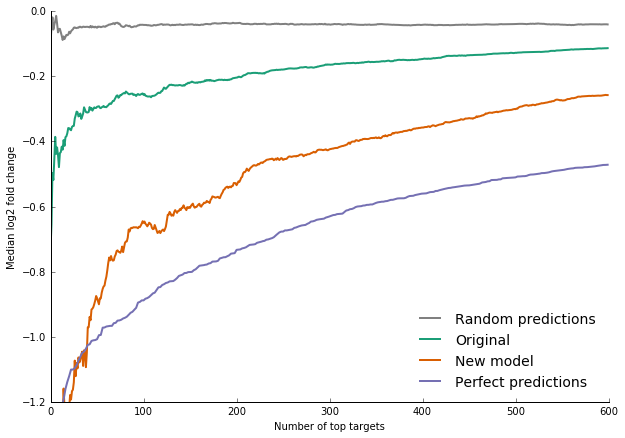

In [439]:
plt.figure(figsize=(10,7))
plt.plot(xrange(topN),random_top_targets_agg,label='Random predictions',color='grey')
# plt.plot(xrange(topN),targetscan7_top_targets_agg,label='Targetscan7')
# plt.plot(xrange(topN),targetscan7_top_targets_cons_agg,label='Targetscan7(cons)')
plt.plot(xrange(topN),original_top_targets_agg,label='Original')
plt.plot(xrange(topN),my_top_targets_agg,label='New model')
plt.plot(xrange(topN),perfect_top_targets_agg,label='Perfect predictions')
plt.xlim(0,topN)
plt.ylim(-1.2,0.0)

plt.xlabel('Number of top targets')
plt.ylabel('Median log2 fold change')
plt.legend(frameon=False,loc='lower right',fontsize=14)
remove_border()

In [ ]:
labels = ['Threep score', 'Local AU score', 'Min dist score', 'siRNA 1A', 'siRNA 1C', 'siRNA 1G', 'siRNA 8A', 
          'siRNA 8C', 'siRNA 8G', 'site 8A', 'site 8C', 'site 8G', 'UTR length score', 'SA', 'ORF length', 
          'ORF 8mers', 'Off6m score', 'TA', 'SPS', 'PCT']
max_diff1 = [0.0, 0.00049868398999985963, 0.00095438334000030878, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 
             0.00058918744000058254, 1.0907161994599996, 0.0004146524299999399, 1.0, 1.09114199669, 0.0, 0.0, 
             0.00029237924730000225]

# max_diff2 = [0.0, 0.00049868398999985963, 0.00095438334000030878, 0.00058918744000058254, 0.00049056496999999588, 
#              0.0004146524299999399, 1.0, 1.09114199669, 0.0, 0.0, 0.00029237924730000225]

fig = plt.figure(figsize=[10,4])
ax = plt.subplot()
xs = range(len(max_diff1))
ax.bar(xs,max_diff1,label=labels,color=dark2_colors[0])
# ax.bar(xs,max_diff2,label=labels,color=dark2_colors[1])
ax.set_xticks([x+0.4 for x in xs])
ax.set_xticklabels(labels,rotation=90)
ax.set_ylabel('Maximum difference')
remove_border()